# INITIAL WHATEVER

In [18]:
import math
import numpy
import numpy.random
import matplotlib
import matplotlib.pyplot as plt


from pt.plotter import *
set_default_plotter_options({
    'num_anomalies': [1, 2, 3, 4, 5],
    'transaction_events': [
        numpy.floor(10**x) for x in 
        [2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4, 4.25, 4.5]
    ],
})

(array([  20.,  126.,  402.,  338.,   94.,   16.,    1.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
      

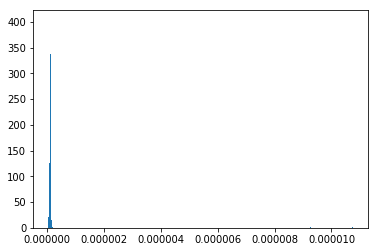

In [26]:
%matplotlib inline

rand = numpy.random.RandomState(seed=1234567)

def gen_data(events, *times):
    x = rand.normal(times[0], times[0]/5, events)
    
    d = 0
    for i in range(1, len(times)):
        t = times[i]
        num_anomalous_events = int(rand.normal(5, 1))
        for e in rand.normal(t, t/5, num_anomalous_events):
            x[d] = e
            d += 1

    numpy.random.shuffle(x)
    return x

x = gen_data(1000, 1e-7, 1e-5)

matplotlib.pyplot.hist(x, 500)

Variables:
1. Number of points
2. Number of anomalies
3. Number of necessary starting data points
4. Frequency/Distribution of anomalies (e.g. what if a bunch happen close together vs far apart?)
5. Frequency/Distribution of data points in time

Experiment:
- Run algorithm on a set of data N times
- Measure the success of each run according to criteria below
- Aggregate that into a single number we can use to compare algorithms

Analysis Criteria:
- some sort of weighted sum of True Positive, False Positive, True Negative, and False Negative
- some sort of overhead calculation

Equipment Needed:
1. Function to generate data with anomalies in it that looks kind of realistic
    - Scrape from existing data
2. Function to calculate success criteria from a given run

